<a href="https://colab.research.google.com/github/abeebyekeen/DLforBeginners/blob/main/CNN_examples1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks (CNNs) and Fully Connected Networks (FCNs)**
Welcome to our deep learning lecture where we delve into the fascinating world of Convolutional Neural Networks (CNNs) and Fully Connected Networks (FCNs). This Jupyter Notebook serves as a practical guide and interactive platform for understanding, implementing, and comparing these two pivotal models in the field of deep learning.

**Convolutional Neural Networks (CNNs)**
 This architecture consists of convolutional layers, pooling layers, and fully connected layers, each playing a distinct role in extracting and processing features from input data.

**Fully Connected Networks (FCNs)**
On the other hand, FCNs, often referred to as dense networks, are a type of neural network where every neuron in one layer is connected to every neuron in the next layer.

In this lecture, we aim to:

* Implement CNN and FCN models using Pytorch.

* Train and compare the two models on a dataset to observe their performance.

By the end of this lecture, you will have a deeper understanding of these two neural network architectures, hands-on experience in implementing them, and practical insights into their comparative performance. Let's dive into the world of deep learning and explore the capabilities of CNNs and FCNs!

In [ ]:
# box 3.1
#%%  CNN vs FCN example: This dataset is designed to predict the next binary value (1 or 0)
# For target 0, the difference between the indices of the two 1s should be an even number.
# For target 1, the difference should be an odd number.
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt



# **CNN vs FCN example**:
This dataset is designed to predict the next binary value (1 or 0) of a noisy sine wave, based on the previous n binary values. If you train a model on this dataset, it should learn the underlying periodic pattern of the sine wave, even though the exact values have been binarized and there's added noise.


In [ ]:
# box 3.2
len_data = 100
def generate_data(num_samples=500, tensor_length=20):
    half_samples = num_samples // 2
    data, labels = [], []

    # Generate samples for target 0
    for _ in range(half_samples):
        tensor = torch.zeros(tensor_length)
        while True:
            idx1 = np.random.choice(range(tensor_length), 1, replace=False)
            idx2 = min(idx1+2, tensor_length-1)
            if (idx2 - idx1) ==2:  # Check even difference
                tensor[idx1], tensor[idx2] = 1, 1
                data.append(tensor)
                labels.append(0)
                break

    # Generate samples for target 1
    for _ in range(half_samples):
        tensor = torch.zeros(tensor_length)
        while True:
            idx1 = np.random.choice(range(tensor_length), 1, replace=False)
            idx2 = min(idx1+1, tensor_length-1)
            if (idx2 - idx1) == 1:  # Check odd difference
                tensor[idx1], tensor[idx2] = 1, 1
                data.append(tensor)
                labels.append(1)
                break

    # Convert to torch tensors
    data = torch.stack(data)
    labels = torch.tensor(labels)

    # Shuffle the data
    indices = torch.randperm(num_samples)
    return data[indices], labels[indices]

data, labels = generate_data(num_samples=500, tensor_length=len_data)
# Splitting data into training and testing
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_data, test_data = data[:train_size], data[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]



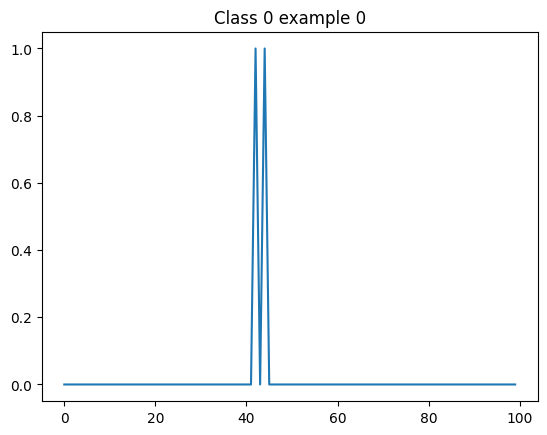

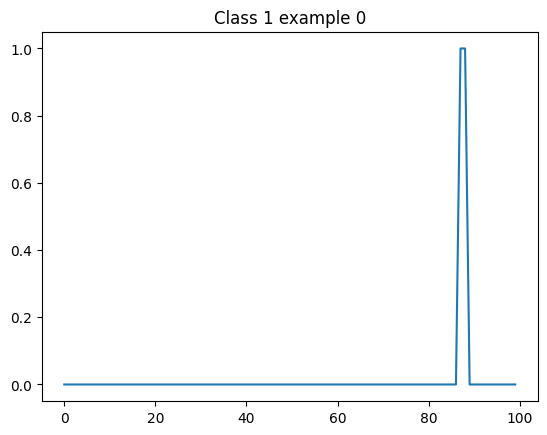

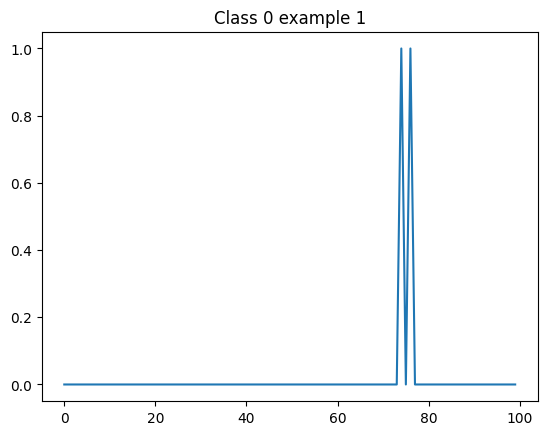

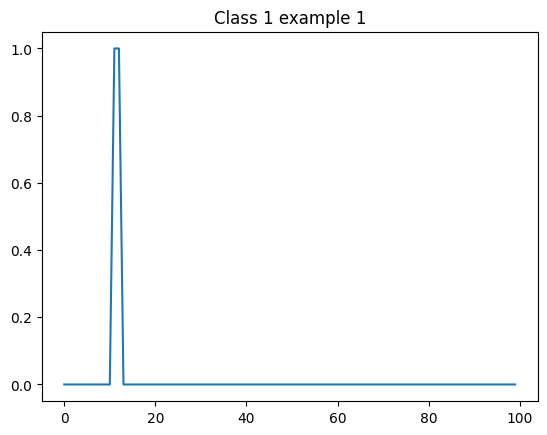

In [ ]:
# box 3.3
#Let's see some examples of two classes
idx_class0 = np.where(train_labels == 0)[0]
idx_class1 = np.where(train_labels == 1)[0]
for i in range(2):
  plt.figure()
  plt.plot(torch.squeeze(train_data[idx_class0[i]]))
  plt.title(f'Class 0 example {i}')
  plt.figure()
  plt.plot(torch.squeeze(train_data[idx_class1[i]]))
  plt.title(f'Class 1 example {i}')


In [ ]:
# box 3.4
# PyTorch "dataset" class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,i):
        return self.X[i],self.Y[i]
#dataset class objects
dataset_train = MyDataset(train_data,train_labels)
dataset_infer = MyDataset(test_data,train_labels)
#dataloaders class objects
bs = 16
dataloader_train = DataLoader(dataset_train,batch_size=bs, shuffle=True, drop_last=True)
dataloader_infer = DataLoader(dataset_infer,batch_size=bs, shuffle=False, drop_last=False)

## From the dataset, what CNN model do you think we should design to classify?

- What are the input size and output size?
- How many layers should we have?
- What are sizes of Convolution layers/filters? How to have the model's output size same as tartget output's size?
- What is the range of the output?
- What activation function (RELU, Sigmoid) will you use and why?


In [ ]:
# box 3.5
class CustomConv1DModel(nn.Module):
    def __init__(self):
        super(CustomConv1DModel, self).__init__()
        # Define a Conv1d layer with 1 input channel, 1 output channel, kernel size of 2
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)

        # Manually set the weights to [...,...] and freeze them
        with torch.no_grad():
            self.conv1d.weight = nn.Parameter(torch.tensor([[[..., ...]]])) # Enter the weight values
            self.conv1d.bias = nn.Parameter(torch.tensor([...])) # Enter the bias values
        self.conv1d.weight.requires_grad = False
        self.conv1d.bias.requires_grad = False

        #comment out ('ctrl'+'/') if you don't want to use linear function
        self.fc1 = nn.Linear(..., 1) # use if have two convolution layer. Enter the in_feature
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(torch.ones((1,...)))
            self.fc1.bias = nn.Parameter(torch.tensor([0.0]))
        self.fc1.weight.requires_grad = False
        self.fc1.bias.requires_grad = False


    def forward(self, x):
        # Apply the convolution
        x = x.unsqueeze(1)
        x = self.conv1d(x)
        x = F.relu(x)
        x = self.fc1(x).squeeze() #comment out ('ctrl'+'/') if you don't want to use linear function
        x = torch.sigmoid(x)
        return x


In [ ]:
# box 3.6
# let's test our defined model
my_model = CustomConv1DModel()
my_model.eval()
with torch.no_grad():
    test_outputs = my_model(test_data)
    test_outputs = torch.where(test_outputs > 0.5, 1, 0)
    correct_cnn = (test_outputs == test_labels).sum().item()
    accuracy_cnn = 100 * correct_cnn / test_size
    print(f"CNN Test Accuracy: {accuracy_cnn:.2f}%")

In [ ]:
# box 3.7
# CNN Model
class TimeCNN(nn.Module):
    def __init__(self):
        super(TimeCNN, self).__init__()
        self.conv1 = nn.Conv1d(1,..., kernel_size=5, padding=2) #Enter the out_channel
        # self.fc1 = nn.Linear(..., 1) # use if have only one convolution layer
        self.conv2 = nn.Conv1d(....,..., kernel_size=..., padding=...) # use if have two convolution layer. Enter the in_channel,out_channel, kernel_size, and padding)
        self.fc1 = nn.Linear(..., 1) # Enter the in_feature values

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)) # use if have two convolution layer
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x.squeeze()

# FCN Model
class TimeFCN(nn.Module):
    def __init__(self):
        super(TimeFCN, self).__init__()
        self.fc1 = nn.Linear(len_data,...) #Enter the out_feature
        self.fc2 = nn.Linear(..., 1) #Enter the in_feature

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

In [ ]:
# box 3.8
##use dataset with batches
criterion = nn.BCELoss()
####add batch size
### drop the FCN in CNN and replace by max or mean

# Train CNN
cnn = TimeCNN()
# optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.01)
epochs = 200
loss_cnn_train_mean = []
loss_cnn_test_mean = []
for epoch in range(epochs):
  loss_cnn_train = []
  loss_cnn_test = []

  # Training loop
  for i, batch_data in enumerate(dataloader_train):
      x, y = batch_data
      optimizer_cnn.zero_grad()
      outputs = cnn(x)
      loss = criterion(outputs, y.float())
      loss.backward()
      optimizer_cnn.step()
      loss_cnn_train.append(loss.item())

  # Compute loss value in testing data
  with torch.no_grad():
      test_outputs = cnn(test_data)
      loss = criterion(test_outputs, test_labels.float())
      loss_cnn_test_mean.append(loss.item())
  # print(f"Epoch {epoch+1}/{epochs}, CNN Loss: {loss.item()}")

  loss_cnn_train_mean.append(torch.tensor(loss_cnn_train).mean())

loss_cnn_test_mean = torch.tensor(loss_cnn_test_mean)

# Train FCN
fcn = TimeFCN()
# optimizer_fcn = torch.optim.Adam(fcn.parameters(), lr=0.001)
optimizer_fcn = torch.optim.Adam(fcn.parameters(), lr=0.001, weight_decay=0.01)
loss_fcn_train_mean = []
loss_fcn_test_mean = []
for epoch in range(epochs):
  loss_fcn_train = []
  loss_fcn_test = []

  # Training loop
  for i, batch_data in enumerate(dataloader_train):
    x, y = batch_data
    optimizer_fcn.zero_grad()
    outputs = fcn(x)
    loss = criterion(outputs, y.float())
    loss.backward()
    optimizer_fcn.step()
    loss_fcn_train.append(loss.item())

  # Compute loss value in testing data
  with torch.no_grad():
    test_outputs = fcn(test_data)
    loss = criterion(test_outputs, test_labels.float())
    loss_fcn_test_mean.append(loss.item())
  # print(f"Epoch {epoch+1}/{epochs}, FCN Loss: {loss.item()}")

  loss_fcn_train_mean.append(torch.tensor(loss_fcn_train).mean())
loss_fcn_test_mean = torch.tensor(loss_fcn_test_mean)

In [ ]:
# box 3.9
# Evaluate CNN at
cnn.eval()
with torch.no_grad():
    test_outputs = cnn(test_data)
    test_outputs = torch.where(test_outputs > 0.5, 1, 0)
    correct_cnn = (test_outputs == test_labels).sum().item()
    accuracy_cnn = 100 * correct_cnn / test_size
    print(f"CNN Test Accuracy: {accuracy_cnn:.2f}%")

# Evaluate FCN
fcn.eval()
with torch.no_grad():
    test_outputs = fcn(test_data)
    test_outputs = torch.where(test_outputs > 0.5, 1, 0)
    correct_fcn = (test_outputs == test_labels).sum().item()
    accuracy_fcn = 100 * correct_fcn / test_size
    print(f"FCN Test Accuracy: {accuracy_fcn:.2f}%")


In [ ]:
# box 3.10
#Plot the loss values
import matplotlib.pyplot as plt
plt.plot(loss_fcn_train_mean, label="FCN - Train")
plt.plot(loss_cnn_train_mean, label="CNN - Train")
plt.plot(loss_fcn_test_mean, label="FCN - Test")
plt.plot(loss_cnn_test_mean, label="CNN - Test")
plt.xlabel('Epoch')
plt.legend()
plt.title("Loss")
plt.show()

total_params = sum(p.numel() for p in fcn.parameters())
print(f'Number of parameters in FCN: {total_params}')
total_params = sum(p.numel() for p in cnn.parameters())
print(f'Number of parameters in CNN: {total_params}')



# **Discussion:**
**Convolutional Neural Networks (CNNs)**
CNNs represent a breakthrough in the analysis of visual imagery. They are primarily used in image recognition and processing, leveraging their ability to learn spatial hierarchies of features through their unique architecture. This architecture consists of convolutional layers, pooling layers, and fully connected layers, each playing a distinct role in extracting and processing features from input data.

**Fully Connected Networks (FCNs)**
On the other hand, FCNs, often referred to as dense networks, are a type of neural network where every neuron in one layer is connected to every neuron in the next layer. This architecture is simple yet powerful and is widely used in various applications beyond image processing, such as speech recognition and natural language processing.